In [77]:
# importing important modules 
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd


In [78]:
# path to CSV files that are the base data
listings = Path("Resources/listings.csv")
medinc = Path("Resources/medinc.csv")

# read our data, as you can see, there's a bunch of stuff I don't need
listings_df = pd.read_csv(listings)
listings_df.head()


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,958,Serviced apartment in San Francisco · ★4.87 · ...,1169,Holly,NaN,Western Addition,37.77028,-122.43317,Entire home/apt,187,2,405,2023-08-07,2.36,1,150,45,City Registration Pending
1,5858,Rental unit in San Francisco · ★4.88 · 2 bedro...,8904,Philip And Tania,NaN,Bernal Heights,37.74474,-122.42089,Entire home/apt,235,30,111,2017-08-06,0.64,1,365,0,NaN
2,8142,Rental unit in San Francisco · ★4.70 · 1 bedro...,21994,Aaron,NaN,Haight Ashbury,37.76555,-122.45213,Private room,56,32,10,2023-07-30,0.09,15,363,2,NaN
3,8339,Condo in San Francisco · ★4.87 · 1 bedroom · 1...,24215,Rosy,NaN,Western Addition,37.77564,-122.43642,Entire home/apt,480,5,28,2019-06-28,0.16,2,365,0,STR-0000264
4,8739,Condo in San Francisco · ★4.92 · 1 bedroom · 1...,7149,Ivan & Wendy,NaN,Mission,37.76030,-122.42197,Private room,122,1,792,2023-08-21,4.62,2,148,39,STR-0000028


## Part 1: Cleaning AirBNB listing data

In [79]:
#In this block, I'm doing the math that will take the listings.csv data 
# and make it similar to the data that is in the later Census data medinc.csv.
# I also get rid of the data I don't need using drop. 

listings_df.set_index('id')
listings_clean = listings_df.drop(['name', 'host_id', 'host_name', 'neighbourhood_group', 
                                   'neighbourhood', 'latitude', 'longitude', 'room_type', 
                                   'minimum_nights', 'number_of_reviews', 'last_review', 
                                   'reviews_per_month', 'calculated_host_listings_count', 
                                   'number_of_reviews_ltm', 'license'], axis=1)
listings_clean["nights_used"] = 365 - listings_clean["availability_365"]
listings_clean["possible_income"] = listings_clean["price"]*365
listings_clean["actual_income"] = listings_clean["nights_used"]*listings_clean["price"]
named_listings = listings_clean.rename(columns={"price":"Price Per Night ($)", 
                                                "availability_365":"Vacancy, Last 365 Days", 
                                                "nights_used":"Occupancy, Last 365 Days", 
                                                "possible_income":"Possible Yearly Income", 
                                                "actual_income":"Actual Yearly Income"})
named_listings.head()


,id,Price Per Night ($),"Vacancy, Last 365 Days","Occupancy, Last 365 Days",Possible Yearly Income,Actual Yearly Income
0,958,187,150,215,68255,40205
1,5858,235,365,0,85775,0
2,8142,56,363,2,20440,112
3,8339,480,365,0,175200,0
4,8739,122,148,217,44530,26474


In [80]:
#this is just setting a variable I need later to do some math 

totalprops = (named_listings["id"].count())
totalprops 



7418

In [81]:
#This is bin creation and using cut to put the data I need from the listings.csv file in to bins
# that match the way the Census data is sorted. 

bins = [-1, 10000, 14999, 24999, 34999, 49999, 74999, 99999, 149999, 199999, 1000000]

group_labels = ["Less than $10,000", "$10,000 to 14,999", "$15,000 to 24,999", 
                "$25,000 to 34,999", "$35,000 to 49,999", "$50,000 to 74,999", 
                "$75,000 to 99,999", "$100,000 to 149,999", "$150,000 to 199,999", "$200,000 or more"]
named_listings["Possible Income Group ($)"] = pd.cut(named_listings["Possible Yearly Income"], bins, labels=group_labels)
named_listings["Actual Income Group ($)"] = pd.cut(named_listings["Actual Yearly Income"], bins, labels=group_labels)

#show the dataframe
named_listings.head()

,id,Price Per Night ($),"Vacancy, Last 365 Days","Occupancy, Last 365 Days",Possible Yearly Income,Actual Yearly Income,Possible Income Group ($),Actual Income Group ($)
0,958,187,150,215,68255,40205,"$50,000 to 74,999","$35,000 to 49,999"
1,5858,235,365,0,85775,0,"$75,000 to 99,999","Less than $10,000"
2,8142,56,363,2,20440,112,"$15,000 to 24,999","Less than $10,000"
3,8339,480,365,0,175200,0,"$150,000 to 199,999","Less than $10,000"
4,8739,122,148,217,44530,26474,"$35,000 to 49,999","$25,000 to 34,999"


In [82]:
# This is some math describing the mean income of the BNB listings to display later. 
listingmean = (named_listings['Actual Yearly Income'].sum()) / totalprops
listingmean

66777.05109193853

In [83]:
# This is takes all the counted listings from the bins and convert them to percentages to match the Census data,
# but only based on what the income of the BNB listing had made over the last 365 days. 

total_inc = named_listings.groupby(["Actual Income Group ($)"])["Actual Yearly Income"].count()
total_inc_df = total_inc.to_frame()
total_inc_df = total_inc_df.rename(columns={"Actual Yearly Income":"# of AirBNB properties, Actual Yearly Income"}) 
total_inc_df.index.names = ["Income Group"]
total_inc_df['% of AirBNB properties, Actual Yearly Income'] = (total_inc_df['# of AirBNB properties, Actual Yearly Income'] /
                  totalprops.sum()) * 100
total_inc_df = total_inc_df.round({'% of AirBNB properties, Actual Yearly Income': 2})
total_inc_df = total_inc_df.drop(['# of AirBNB properties, Actual Yearly Income'], axis = 1)
total_inc_df

,"% of AirBNB properties, Actual Yearly Income"
Income Group,
"Less than $10,000",27.26
"$10,000 to 14,999",7.82
"$15,000 to 24,999",14.79
"$25,000 to 34,999",10.15
"$35,000 to 49,999",11.53
"$50,000 to 74,999",12.05
"$75,000 to 99,999",5.38
"$100,000 to 149,999",5.63
"$150,000 to 199,999",1.85


In [84]:
# This is takes all the counted listings from the bins and convert them to percentages to match the Census data,
# but only based on what the income of the BNB listing could have made, had it been occupied all 365 days. 

possible_inc = named_listings.groupby(["Possible Income Group ($)"])["Possible Yearly Income"].count()
possible_inc_df = possible_inc.to_frame()
possible_inc_df = possible_inc_df.rename(columns={"Possible Income Group ($)":"Income Group",
                                                  "Possible Yearly Income":"# of AirBNB properties, Possible Yearly Income"}) 
possible_inc_df['% of AirBNB properties, Possible Yearly Income'] = (possible_inc_df['# of AirBNB properties, Possible Yearly Income'] /
                  totalprops.sum()) * 100
possible_inc_df.index.names = ["Income Group"]
possible_inc_df = possible_inc_df.round({'% of AirBNB properties, Possible Yearly Income': 2})
possible_inc_df = possible_inc_df.drop(['# of AirBNB properties, Possible Yearly Income'], axis = 1)
possible_inc_df



,"% of AirBNB properties, Possible Yearly Income"
Income Group,
"Less than $10,000",0.03
"$10,000 to 14,999",0.80
"$15,000 to 24,999",8.56
"$25,000 to 34,999",12.38
"$35,000 to 49,999",20.07
"$50,000 to 74,999",23.94
"$75,000 to 99,999",11.50
"$100,000 to 149,999",11.89
"$150,000 to 199,999",3.80


In [85]:
#Merging the two dataframes and resetting the index to easily chart for later. 
# At this point, I'm done cleaning up the listings.csv data. 

listingmerge = total_inc_df.merge(possible_inc_df, left_index=True, right_index=True)
listingmerge = listingmerge.reset_index()

listingmerge


,Income Group,"% of AirBNB properties, Actual Yearly Income","% of AirBNB properties, Possible Yearly Income"
0,"Less than $10,000",27.26,0.03
1,"$10,000 to 14,999",7.82,0.80
2,"$15,000 to 24,999",14.79,8.56
3,"$25,000 to 34,999",10.15,12.38
4,"$35,000 to 49,999",11.53,20.07
5,"$50,000 to 74,999",12.05,23.94
6,"$75,000 to 99,999",5.38,11.50
7,"$100,000 to 149,999",5.63,11.89
8,"$150,000 to 199,999",1.85,3.80
9,"$200,000 or more",2.64,5.76


## Part 2: Cleaning US Census data

In [86]:
# Now to clean up the Census data. 

medinc_df = pd.read_csv(medinc)
medinc_df

,Label (Grouping),"San Francisco-Oakland-Berkeley, CA Metro Area!!Households!!Estimate","San Francisco-Oakland-Berkeley, CA Metro Area!!Households!!Margin of Error","San Francisco-Oakland-Berkeley, CA Metro Area!!Families!!Estimate","San Francisco-Oakland-Berkeley, CA Metro Area!!Families!!Margin of Error","San Francisco-Oakland-Berkeley, CA Metro Area!!Married-couple families!!Estimate","San Francisco-Oakland-Berkeley, CA Metro Area!!Married-couple families!!Margin of Error","San Francisco-Oakland-Berkeley, CA Metro Area!!Nonfamily households!!Estimate","San Francisco-Oakland-Berkeley, CA Metro Area!!Nonfamily households!!Margin of Error"
0,Total,"1,739,127","±7,953","1,088,106","±12,703","830,564","±12,235","651,021","±11,608"
1,"Less than $10,000",4.3%,±0.3,2.1%,±0.3,1.1%,±0.2,8.3%,±0.7
2,"$10,000 to $14,999",2.8%,±0.3,1.2%,±0.2,0.9%,±0.2,5.6%,±0.6
3,"$15,000 to $24,999",4.2%,±0.3,2.9%,±0.3,2.1%,±0.3,6.8%,±0.5
4,"$25,000 to $34,999",4.0%,±0.3,3.0%,±0.3,2.2%,±0.3,5.7%,±0.5
5,"$35,000 to $49,999",5.9%,±0.4,5.5%,±0.4,3.8%,±0.4,7.5%,±0.5
6,"$50,000 to $74,999",9.7%,±0.4,8.5%,±0.5,6.6%,±0.5,12.0%,±0.7
7,"$75,000 to $99,999",9.7%,±0.4,9.3%,±0.5,8.0%,±0.5,11.0%,±0.7
8,"$100,000 to $149,999",15.8%,±0.5,15.4%,±0.6,14.9%,±0.7,15.8%,±0.9
9,"$150,000 to $199,999",11.9%,±0.4,12.9%,±0.6,13.7%,±0.7,9.7%,±0.6


In [87]:

#made a new dataframe with just the columns I need instead of dropping a bunch of columns
medinc_clean = medinc_df[['Label (Grouping)', 'San Francisco-Oakland-Berkeley, CA Metro Area!!Households!!Estimate']]
#renamed columns
named_medinc = medinc_clean.rename(columns={"Label (Grouping)":"Income Group", 
                                            "San Francisco-Oakland-Berkeley, CA Metro Area!!Households!!Estimate":"Estimated Household Income"})
#dropped unnecessary rows of data that broke down numbers into further demographics
named_medinc = named_medinc.drop([0, 11, 12, 13, 14, 15, 16], axis = 0)
#strips % from data
named_medinc['Estimated Household Income'] = named_medinc['Estimated Household Income'].str.strip(to_strip="%")
#had to rename the index because of funky LaTeX encoding in order to properly merge BNB data with Census data
named_medinc = named_medinc.replace({'    Less than $10,000':'Less than $10,000',
                                     '    $10,000 to $14,999':'$10,000 to 14,999',
                                     '    $15,000 to $24,999':'$15,000 to 24,999',
                                     '    $25,000 to $34,999':'$25,000 to 34,999',
                                     '    $35,000 to $49,999':'$35,000 to 49,999',
                                     '    $50,000 to $74,999':'$50,000 to 74,999',
                                     '    $75,000 to $99,999':'$75,000 to 99,999',
                                     '    $100,000 to $149,999':'$100,000 to 149,999',
                                     '    $150,000 to $199,999':'$150,000 to 199,999',
                                     '    $200,000 or more':'$200,000 or more'})
named_medinc = named_medinc.set_index('Income Group')
named_medinc = named_medinc.astype({'Estimated Household Income': 'float64'})
named_medinc

,Estimated Household Income
Income Group,
"Less than $10,000",4.3
"$10,000 to 14,999",2.8
"$15,000 to 24,999",4.2
"$25,000 to 34,999",4.0
"$35,000 to 49,999",5.9
"$50,000 to 74,999",9.7
"$75,000 to 99,999",9.7
"$100,000 to 149,999",15.8
"$150,000 to 199,999",11.9


In [88]:
# Merged two data frames to start off with. One of my listings frames is being merged into the Census data. 


datamerge1 = named_medinc.merge(possible_inc_df, left_index=True, right_index=True)
datamerge1

,Estimated Household Income,"% of AirBNB properties, Possible Yearly Income"
Income Group,,
"Less than $10,000",4.3,0.03
"$10,000 to 14,999",2.8,0.80
"$15,000 to 24,999",4.2,8.56
"$25,000 to 34,999",4.0,12.38
"$35,000 to 49,999",5.9,20.07
"$50,000 to 74,999",9.7,23.94
"$75,000 to 99,999",9.7,11.50
"$100,000 to 149,999",15.8,11.89
"$150,000 to 199,999",11.9,3.80


In [89]:
# Now merging the other listings frame into the above frame to create the final frame needed to collate all of the data.
# We should now be able to make some visuals. 

merged_data = datamerge1.merge(total_inc_df, left_index=True, right_index=True)
merged_data = merged_data.rename(columns={"% of AirBNB properties, Possible Yearly Income":"AirBNB Listings, Possible Yearly Income", 
                                            "% of AirBNB properties, Actual Yearly Income":"AirBNB Listings, Actual Yearly Income"})
merged_data = merged_data.reset_index()
merged_data

,Income Group,Estimated Household Income,"AirBNB Listings, Possible Yearly Income","AirBNB Listings, Actual Yearly Income"
0,"Less than $10,000",4.3,0.03,27.26
1,"$10,000 to 14,999",2.8,0.80,7.82
2,"$15,000 to 24,999",4.2,8.56,14.79
3,"$25,000 to 34,999",4.0,12.38,10.15
4,"$35,000 to 49,999",5.9,20.07,11.53
5,"$50,000 to 74,999",9.7,23.94,12.05
6,"$75,000 to 99,999",9.7,11.50,5.38
7,"$100,000 to 149,999",15.8,11.89,5.63
8,"$150,000 to 199,999",11.9,3.80,1.85
9,"$200,000 or more",31.7,5.76,2.64


## Part 3: Displaying our cleaned data

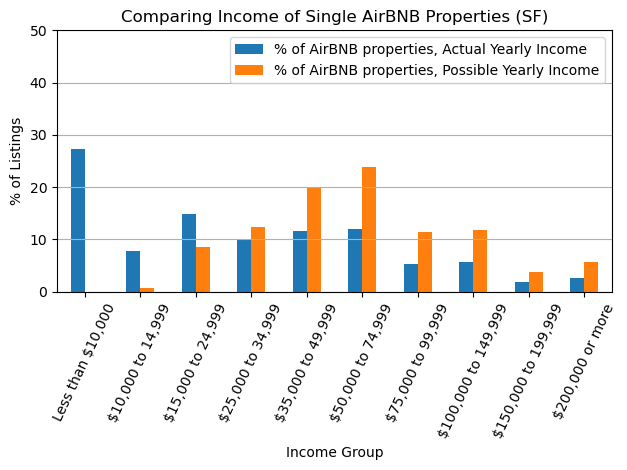

In [90]:
#This is a simple graph displaying the differences in possible and actual income for BNB listings in the city. 

listingmerge.plot(x="Income Group", kind="bar", rot=65)
plt.ylim((0, 50))
plt.title("Comparing Income of Single AirBNB Properties (SF)")
plt.xlabel("Income Group")
plt.ylabel("% of Listings")
plt.grid(which="major", axis="y")
plt.tight_layout()
plt.savefig("Images/ComparingListingIncome.png")
plt.show()

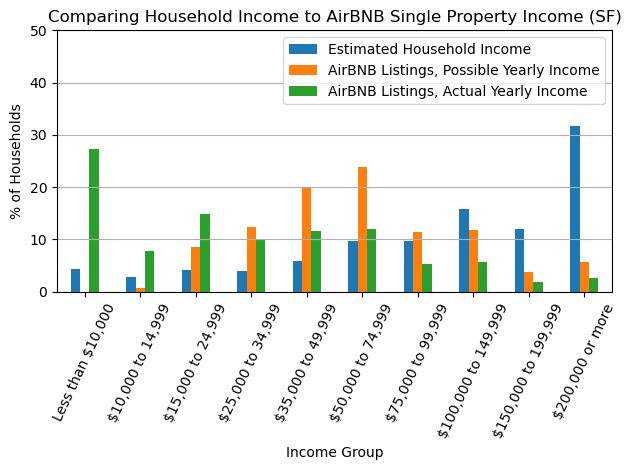

In [91]:
# This is the final part of collating all the data together into one graph for presentation. 

merged_data.plot(x="Income Group", kind="bar", rot=65)
plt.ylim((0, 50))
plt.title("Comparing Household Income to AirBNB Single Property Income (SF)")
plt.xlabel("Income Group")
plt.ylabel("% of Households")
plt.grid(which="major", axis="y")
plt.tight_layout()
plt.savefig("Images/ComparingLocalIncome.png")
plt.show()
    
